In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

In [88]:
location=[1,2]
max_car_num=20
reward_rent_onecar=10
cost_move_onecar=2
move_1day_max_car_num=5
requests_avg=[3,4]
returns_avg=[3,2]
gamma=0.9
theta=0.0001
action=np.arange(-move_1day_max_car_num,move_1day_max_car_num+1)
value = np.zeros((max_car_num+1, max_car_num+1))    
policy = np.zeros(value.shape, dtype=int)
poisson_cache = dict()
value_history=[]

In [89]:
# def action_choice_prob(n,lamda):
#     action_visited=poisson.pmf(n,lamda)
#     return action_visited

In [90]:
def action_choice_prob(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        # 计算泊松概率
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

In [91]:
# def state_value_compute(act,state,state_value):
#     state_value_update=0.0
#     state_value_update-=cost_move_onecar*abs(act)
#     state_value_max=[]
#     for i in range(10+1):
#         for j in range(10+1):
#             request_prob=action_choice_prob(i,requests_avg[0])*action_choice_prob(j,requests_avg[1])
#             curr_1_car_num=min(state[0]-act,max_car_num)
#             curr_2_car_num=min(state[1]+act,max_car_num)
#             rent_from1_available_car_num=min(curr_1_car_num,i)
#             rent_from2_available_car_num=min(curr_2_car_num,j)
#             curr_reward=(rent_from1_available_car_num+rent_from2_available_car_num)*reward_rent_onecar
#             curr_1_car_num-=rent_from1_available_car_num
#             curr_2_car_num-=rent_from2_available_car_num
#             for m in range(10+1):
#                 for n in range(10+1):
#                     return_prob=action_choice_prob(m,returns_avg[0])*action_choice_prob(n,returns_avg[1])
#                     curr_1_car_num_follow=min(curr_1_car_num+m,max_car_num)
#                     curr_2_car_num_follow=min(curr_2_car_num+n,max_car_num)
#                     prob_transition=return_prob*request_prob
#                     state_value_max.append(prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow]))
#                     state_value_update+=prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow])
#             # state_value_max1=state_value_max
#             # if -11<=np.argmax(state_value_max1)<=11:
#             #     curr_best_action=action[np.argmax(state_value_max1)]
#             #     policy[i,j]=curr_best_action
#     # state_value_max_=max(state_value_max)
#     return state_value_update

In [92]:
def state_value_compute(act,state,state_value,return_cars):
    state_value_update=0.0
    state_value_update-=cost_move_onecar*abs(act)
    state_value_max=[]
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            request_prob=action_choice_prob(i,requests_avg[0])*action_choice_prob(j,requests_avg[1])
            curr_1_car_num=min(state[0]-act,max_car_num)
            curr_2_car_num=min(state[1]+act,max_car_num)
            rent_from1_available_car_num=min(curr_1_car_num,i)
            rent_from2_available_car_num=min(curr_2_car_num,j)
            curr_reward=(rent_from1_available_car_num+rent_from2_available_car_num)*reward_rent_onecar
            curr_1_car_num-=rent_from1_available_car_num
            curr_2_car_num-=rent_from2_available_car_num
            # if return_cars:
            #     curr_1_car_num_follow=min(curr_1_car_num+returns_avg[0],max_car_num)
            #     curr_2_car_num_follow=min(curr_2_car_num+returns_avg[1],max_car_num)
            #     # prob_transition=return_prob*request_prob
            #     # state_value_max.append(prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow]))
            #     state_value_update+=request_prob*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow])
            # else:
            for m in range(max_car_num+1):
                for n in range(max_car_num+1):
                    return_prob=action_choice_prob(m,returns_avg[0])*action_choice_prob(n,returns_avg[1])
                    curr_1_car_num_follow=min(curr_1_car_num+m,max_car_num)
                    curr_2_car_num_follow=min(curr_2_car_num+n,max_car_num)
                    prob_transition=return_prob*request_prob
                    state_value_max.append(prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow]))
                    state_value_update+=prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow])
                # state_value_max1=state_value_max
                # if -11<=np.argmax(state_value_max1)<=11:
                #     curr_best_action=action[np.argmax(state_value_max1)]
                #     policy[i,j]=curr_best_action
    # state_value_max_=max(state_value_max)
    return state_value_update

In [93]:
def policy_evaluation():
    while True:
        pre_value=value.copy()
        for i in range(max_car_num+1):
            for j in range(max_car_num+1):
                state_value_update=state_value_compute(policy[i,j],[i,j],value)
                value[i,j]=state_value_update
        delta=abs(pre_value-value).max()
        print(f'delta: {delta}')
        if delta<theta:
            break
    return value

In [94]:
def policy_improvement():
    policy_stable=True
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            old_action=policy[i,j]
            action_update=[]
            for k in action:
                if i>=k and -j<=k :
                    action_update.append(state_value_compute(k,[i,j],value))
                else:
                    action_update.append(-np.inf)
            curr_best_action=action[np.argmax(action_update)]
            policy[i,j]=curr_best_action
            if old_action!=curr_best_action and policy_stable:
                policy_stable=False
            # action_update=np.array(action_update)
            # curr_best_action=action[np.where(action_update==action_update.max())[0]]
            # policy[i,j]=np.random.choice(curr_best_action)
            # if policy_stable and (old_action not in curr_best_action):
            #     policy_stable=False
    return policy_stable,policy
    

In [95]:
def value_evalution():
    iter=0
    while True:
        pre_value=value.copy()
        value_history.append(pre_value)
        for i in range(max_car_num+1):
            for j in range(max_car_num+1):
                value_update=[]
                for k in action:
                    if i>=k and -j<=k :
                        value_update.append(state_value_compute(k,[i,j],value,return_cars=True))
                    else:
                        value_update.append(-np.inf)
                value_best=np.max(value_update)
                value[i,j]=value_best
        # for i in range(max_car_num+1):
        #     for j in range(max_car_num+1):
        #         state_value_update=state_value_compute(policy[i,j],[i,j],value)
        #         value[i,j]=state_value_update
        delta=abs(pre_value-value).max()
        print(f'delta: {delta}')
        # draw_fig(value,policy_update,iter)
        iter+=1
        if delta<theta:
            value_history.append(value)
            break
    return value

In [96]:
def policy_from_optimal_value():
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            value_update=[]
            for k in action:
                if i>=k and -j<=k :
                    value_update.append(state_value_compute(k,[i,j],value,return_cars=True))
                else:
                    value_update.append(-np.inf)
            policy[i,j]=action[np.argmax(np.round(value_update,5))]
    return policy

In [97]:
def draw_fig(value, policy):
    fig = plt.figure(figsize=(15, 15)) 
    ax = fig.add_subplot(121)    
    ax.matshow(policy, cmap=plt.cm.bwr, vmin=-move_1day_max_car_num, vmax=move_1day_max_car_num)
    ax.set_xticks(range(max_car_num+1))
    ax.set_yticks(range(max_car_num+1))
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xlabel("Cars at second location")
    ax.set_ylabel("Cars at first location")
    for x in range(max_car_num+1):
        for y in range(max_car_num+1):
            ax.text(x=x, y=y, s=int(policy.T[x, y]), va='center', ha='center', fontsize=8)
    ax.set_title(r'$\pi_{value}$', fontsize=20)

    y, x = np.meshgrid(range(max_car_num+1), range(max_car_num+1))
    ax = fig.add_subplot(122, projection='3d')   
    ax.scatter3D(y, x, value.T)
    ax.set_xlim3d(0, max_car_num)
    ax.set_ylim3d(0, max_car_num)
    ax.set_xlabel("Cars at second location")
    ax.set_ylabel("Cars at first location")
    ax.set_title('value for ' + r'$\pi_{value}$', fontsize=20)
    plt.savefig(f'value.png', bbox_inches='tight')

In [98]:
# def draw_fig():
#     plt.figure()
#     plt.subplot(211)
#     for sweep, state_value in enumerate(value_history):
#         plt.plot(state_value, label=f'sweep {sweep}')
#     plt.xlabel('Capital')
#     plt.ylabel('Value estimates')
#     plt.legend(loc='best', bbox_to_anchor=(1, 1))

#     plt.subplot(212)
#     # plt.scatter(STATES[1:GOAL], policy[1:GOAL])
#     # plt.plot(policy)
#     plt.bar(value, policy)
#     print(value.shape(),policy.shape())
#     plt.xlim(-max_car_num, max_car_num)
#     # plt.ylim(0, GOAL/2+1)
#     plt.xticks(np.arange(0, max_car_num, 5))
#     plt.xlabel('Capital')
#     plt.ylabel('Final policy (stake)')
#     plt.savefig(f'value_T.png', bbox_inches='tight')
#     # plt.show()

In [99]:
def policy_iteration():
    iter=0
    while True:
        value_update=policy_evaluation()
        stable,policy_update=policy_improvement()
        iter+=1
        print('iteration: {}, policy stable {}'.format(iter, stable))
        draw_fig(value_update,policy_update,iter)
        if stable==True:
            break

delta: 295.6037706554003
delta: 111.51738887581577
delta: 88.00042485152292
delta: 66.24878004106284
delta: 49.97781636751131
delta: 38.5449674120199
delta: 31.327380249967007
delta: 25.75802943374555
delta: 21.132826592849938
delta: 17.318295921281845
delta: 14.18318282010739
delta: 11.61298548879364
delta: 9.507900328124435
delta: 7.783924594576774
delta: 6.372488571295321
delta: 5.217161137836001
delta: 4.271343157280739
delta: 3.497045291248128
delta: 2.8631921948061745
delta: 2.344296654162747
delta: 1.9194883911449097
delta: 1.5716900643905092
delta: 1.2869298230113486
delta: 1.0537780544906923
delta: 0.8628820705024509
delta: 0.7065808495779038
delta: 0.5786004020781661
delta: 0.47380802428926927
delta: 0.3880012394095047
delta: 0.31773897551761365
delta: 0.2602036659197893
delta: 0.21308864126558547
delta: 0.17450575295760018
delta: 0.14290938886642834
delta: 0.11703418536171739
delta: 0.09584409470534183
delta: 0.07849075160879693
delta: 0.06427943297774164
delta: 0.0526412176

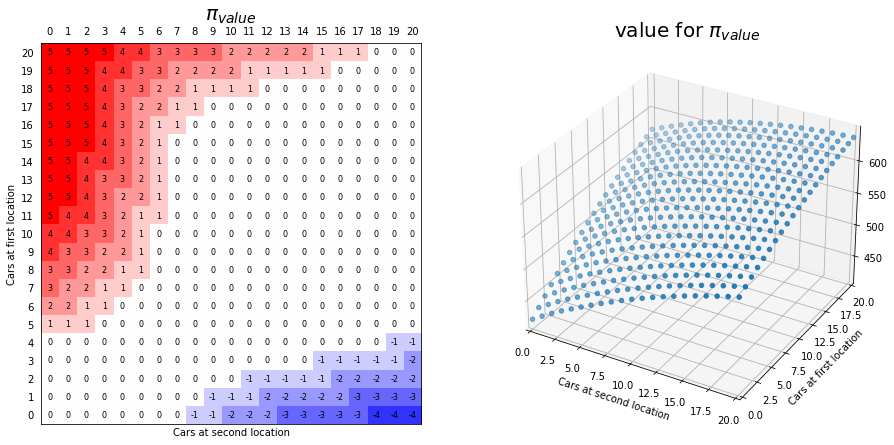

In [100]:
if __name__ == '__main__':
    # policy_iteration()
    value_update=value_evalution()
    policy_update=policy_from_optimal_value()
    draw_fig(value_update,policy_update)

In [101]:
# if __name__ == '__main__':
#     iter=0
#     while True:
#         value_update=policy_evaluation()
#         stable,policy_update=policy_improvement()
#         iter+=1
#         print('iteration: {}, policy stable {}'.format(iter, stable))
#         draw_fig(value_update,policy_update,iter)
#         if stable==True:
#             break
        